In [1]:
import underworld as uw
import glucifer
import numpy
import matplotlib.pyplot as plt
import mpi4py

uw.matplotlib_inline()
plt.ion()

comm = mpi4py.MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Whether or not to save figures to files in the current directory.
#    Mainly useful when not using a notebook or for comparisons.
savefigures = False

### Groundwater Flow

Underworld can efficiently solve the diffusion-advection equation and can set up as many simultaneous instances of it in a model as we would like. Heat-flow and groundwater flow are both described by this equation, so we can set these up and couple them, to model temperature advection by groundwater.

**Temperature Diffusion-Advection Equation**

$\frac{\partial T} {\partial t} = \kappa \nabla^2 T + G$


where: $\kappa = \frac{k}{C_p \rho}$

($\kappa$ - thermal diffusivity, $T$ - temperature, $t$ - time, $G$ - groundwater advection term, $C_p$ - heat capacity, $\rho$ - rock density)

**Groundwater Pressure Diffusion Equation**

$\frac{\partial H} {\partial t} = \kappa_H \nabla^2 H + F$

where: $\kappa_H = \frac{k_H}{\mu S}$

$F = \frac{g}{S} \frac{\partial \rho_w}{\partial y}\ \ \ $assuming constant $\rho_w$, $\ F=0$

($\kappa_H$ - hydraulic diffusivity, $H$ - groundwater pressure,  $k_H$ - hydraulic permeability, $\mu$ - water viscosity, $S$ - specific storage, $g$ - gravitational accelleration, $\rho_w$ - density of water)

**Groundwater Flow Equation**

$ q = \frac{k_H}{\mu}\left(\nabla H +  \rho_w g\right) $


**Coupling**

$G = -\nabla T \cdot \frac{\rho_w C_w}{\rho C} q$

($C_w$ - heat capacity of water)

Coupling is implemented by handing an 'effective velocity field', $\frac{\rho_w C_w}{\rho C} q$ to the temperature diffusion-advection solver.


---

*Set up mesh and fields*

In [2]:

elementType = "Q1/dQ0"
resX = 16
resY = 32
mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = (resX, resY), 
                                 minCoord    = (-1., -1.), 
                                 maxCoord    = (1., 0.)) 

temperatureField    = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
temperatureDotField    = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )

gwPressureField    = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
hydraulicDiffusivityField    = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
gwPressureDotField    = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )

velocityField    = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=2 )
zerovelocityField    = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=2 )

domainVolume = (mesh.maxCoord[1] - mesh.minCoord[1]) * (mesh.maxCoord[0] - mesh.minCoord[0])
averageTemperature = uw.utils.Integral(fn = temperatureField / domainVolume,mesh= mesh,integrationType="volume")

*Set up the types of boundary conditions*

In [3]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
insideNodes = []
for i in range(mesh.nodesLocal):
    if i not in iWalls and i not in jWalls:
        insideNodes.append(i)



temperatureBC = uw.conditions.DirichletCondition( variable        = temperatureField, 
                                               indexSetsPerDof = ( jWalls) )

gwPressureBC = uw.conditions.DirichletCondition( variable        = gwPressureField, 
                                               indexSetsPerDof = ( jWalls) )



*Set initial conditions and the values of the boundary conditions*

**This lower ground-water pressure is something that you can change. You can lower it until gravity dominates.**

In [4]:
#Lower groundwater pressure boundary condition
#    this value is relative to gravity
maxgwpressure = 2.

Set up initial conditions. This includes whether or not you want to read in an existing temperature field. We will by default, because we will only run a couple of time steps.

In [5]:
readTemperature = True

yCoordFn = uw.function.input()[1]

if readTemperature:
    temperatureField.load("input/1_13_Groundwater_Flow/temperature.h5", interpolate=True)
else:
    initialFn = -1. * yCoordFn
    temperatureField.data[:] = initialFn.evaluate(mesh)

initialFn = -1. * maxgwpressure * yCoordFn
gwPressureField.data[:] = initialFn.evaluate(mesh)




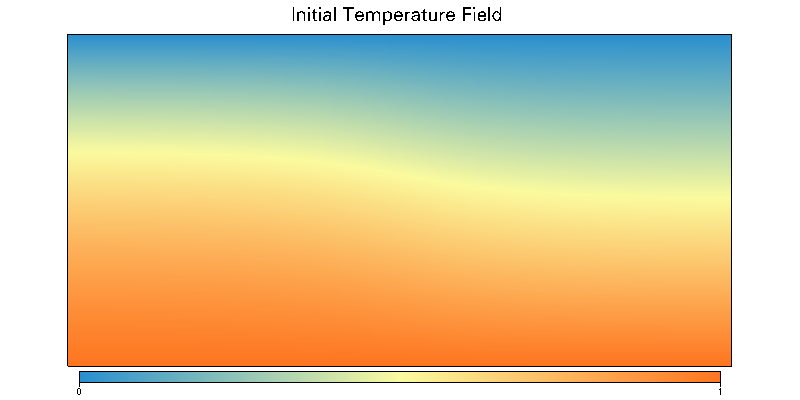

In [6]:
figMaterial = glucifer.Figure( figsize=(800,400), title="Initial Temperature Field" )
figMaterial.append( glucifer.objects.Surface(mesh,temperatureField ))
if size == 1:
    figMaterial.show()


*Set up swarm*

In [7]:
swarm         = uw.swarm.Swarm( mesh=mesh )
swarmLayout   = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=10 )
swarm.populate_using_layout( layout=swarmLayout )

*Assign materials to particles*

** Here we are deciding on the distribution of different materials. The benchmark is for a large region which extends from the bottom to the top of the domain, in this case on the left hand half of the model. Once you are happy with the benchmark, feel free to change the model geometries!** 

In [8]:
materialIndex  = swarm.add_variable( dataType="int",    count=1 )

materialPorous        = 0
materialImpermeable   = 1

xCoordFn = uw.function.input()[0]
yCoordFn = uw.function.input()[1]

conditions = [ (yCoordFn > 0., materialPorous),
                ( xCoordFn < 0. , materialPorous),
               ( True , materialImpermeable )]


materialIndex.data[:]  = uw.function.branching.conditional( conditions ).evaluate(swarm)





*Visualise the materials we have just assigned*


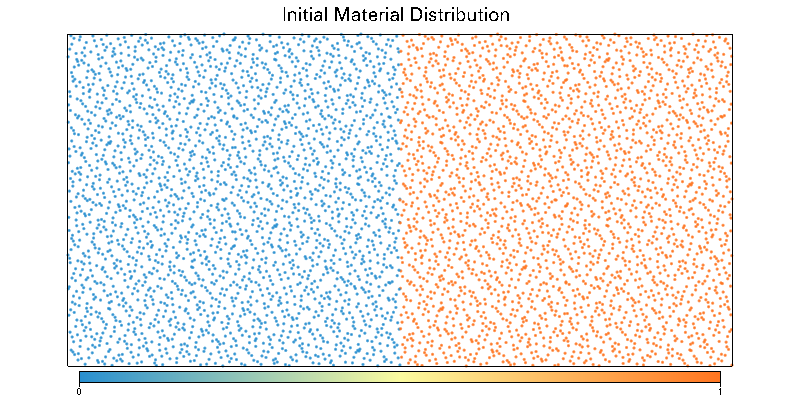

In [9]:
figMaterial = glucifer.Figure( figsize=(800,400), title="Initial Material Distribution" )
figMaterial.append( glucifer.objects.Points(swarm, materialIndex, pointSize=4.0) )
if size == 1:
    figMaterial.show()


*Assign material properties*

**Here we have material properties which are chosen relative to the thermal diffusion time-scale. Leave the thermal diffusivity as 1, but you can change the maximum hydraulic diffusivity to control their relative time-scale (along with the chosen pressure gradient above). Feel free to change it!**

**The storage capacity effectively controls the ratio of groundwater pressure diffusion to groundwater flow. The ratio of $\rho_w c_w / \left( \rho c \right)$ controls the rate of energy transfer from the water to the rock matrix. $\rho_w$ also affects the gravity term in the ground-water flow equation ... denser water will sink in the absence of an upward pressure decrease.**

In [10]:
maxHydDiff = 1.
hydraulicDiffusivityMap = { materialPorous : maxHydDiff, 
                 materialImpermeable : 1e-5}
hydraulicDiffusivityMapFn = uw.function.branching.map( fn_key = materialIndex, mapping = hydraulicDiffusivityMap )

#Hydraulic storage capacity
Storage = 1.

rho_water = 1.
rho_rock = 2.5

c_w = 4000.
c = 1250.

# g = 1.
g = uw.function.misc.constant((0.,1.))


thermalDiff = 1.
thermalDiffusivityMap = { materialPorous : thermalDiff, 
                 materialImpermeable : thermalDiff}
thermalDiffusivityMapFn = uw.function.branching.map( fn_key = materialIndex, mapping = thermalDiffusivityMap )

*Setup groundwater equations*

In [11]:

gwadvDiff = uw.systems.SteadyStateHeat( temperatureField = gwPressureField, fn_diffusivity = hydraulicDiffusivityMapFn,conditions=[gwPressureBC])

gwsolver = uw.systems.Solver(gwadvDiff)

hydraulicProjector = uw.utils.MeshVariable_Projection(hydraulicDiffusivityField,hydraulicDiffusivityMapFn)
hydraulicProjector.solve()


*Gradients - needed for calculating ground-water flow and advection*

In [12]:
tempGrad = temperatureField.fn_gradient
gwPressureGrad = gwPressureField.fn_gradient


*Ground-water Velocity*

In [13]:
gwVelField = -1.*rho_water / rho_rock * c_w / c *(g *rho_water + gwPressureGrad)* hydraulicDiffusivityField * Storage
velocityfieldProjector = uw.utils.MeshVariable_Projection(velocityField,gwVelField)

velocityfieldProjector.solve()



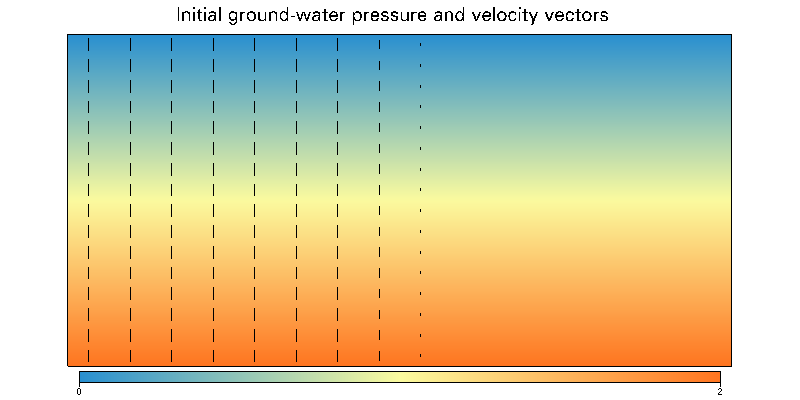

In [14]:
figMaterial = glucifer.Figure( figsize=(800,400), title="Initial ground-water pressure and velocity vectors" )
figMaterial.append( glucifer.objects.Surface(mesh,gwPressureField ))
figMaterial.append(glucifer.objects.VectorArrows(mesh,gwVelField,scaling=0.03))
if size == 1:                   
    figMaterial.show()


*Setup temperature advection-diffusion solver*

In [15]:
tempadvDiff = uw.systems.AdvectionDiffusion( temperatureField, temperatureDotField, 
        velocityField, 
        fn_diffusivity=thermalDiffusivityMapFn, conditions=[temperatureBC,] ) 


For a ground-water velocity $q$, this the following is an analytic solution to the 1D temperature diffusion-advection equation: $\frac{d^2 T}{dy^2} +  q'\frac{dT}{dy} = 0$

where: $q' = \frac{\rho_w c_w}{\rho c} \frac{q}{\kappa}$

The solution, assuming $H=0$ and $T=0$ at the surface and $H = H_{max}$ and $T=1$ at the base of the domain, is:

$T(y) = \alpha \left(e^{q' y} - 1 \right)\ \ \ $ where: $\alpha = \left( e^{-q'}-1 \right)^{-1}$    (you can check it's actually a solution)


We can use this to benchmark an effectively 1D part of the domain.

In [16]:
def analyticsol(y):
    qp = rho_water / rho_rock * c_w / c * maxHydDiff / thermalDiff * Storage * (maxgwpressure - rho_water)
    
    if qp == 0.:
        return -y
    else:
        return (numpy.exp(qp*y) - 1.) / (numpy.exp(-qp) -1. )

We solve for the groundwater pressure diffusion first, as it temperature-independent. Because the temperature advection-diffusion depends on groundwater flow, but not the other way round, we can solve for groundwater pressure first. There is no source term, so we can use the steady-state solver.

In [17]:

gwsolver.solve()

velocityfieldProjector.solve()



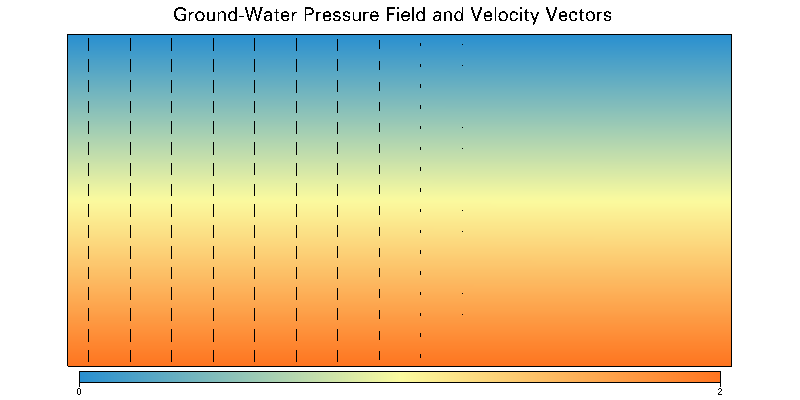

In [18]:
figMaterial = glucifer.Figure( figsize=(800,400),title="Ground-Water Pressure Field and Velocity Vectors" )
figMaterial.append(glucifer.objects.Surface(mesh,gwPressureField,))
scale = 0.03
figMaterial.append(glucifer.objects.VectorArrows(mesh,velocityField*scale,scaling=1.))
if size == 1:
    figMaterial.show()


*Now solve for the temperature.*

**This could certainly take a while to reach a steady-state. Look at the figures below and make sure that the mean temperature does not vary by the end of the loop. If the left hand wall of the model is homogeneous and is therefore effectively 1D, with purely vertical ground-water flow, check that this solution agrees with the analytic solution**

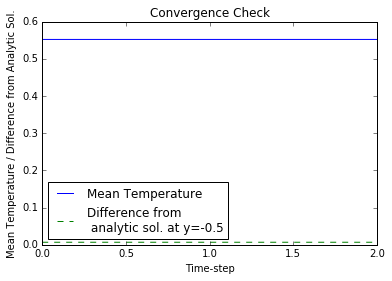

In [19]:
n = 3
arrMeanTemp = numpy.zeros(n)
arrError = numpy.zeros(n)

for i in range(n):
    dt =   tempadvDiff.get_max_dt()
    
    arrMeanTemp[i] = averageTemperature.evaluate()[0]
    midTemp = temperatureField.evaluate_global((-1.,-0.5))
    if rank == 0:
        arrError[i] = abs(analyticsol(-0.5) - midTemp[0])
            
    tempadvDiff.integrate(dt)
    

if rank == 0:
    plt.plot(range(n),arrMeanTemp,label="Mean Temperature")
    plt.plot(range(n),arrError,"--",label="Difference from \n analytic sol. at y=-0.5")

    plt.legend(loc='best')
    plt.xlabel('Time-step')
    plt.ylabel('Mean Temperature / Difference from Analytic Sol.')
    plt.ylim(0,0.6)
    plt.title('Convergence Check')

    if savefigures:
        plt.savefig("AvTemperatureTimestep.pdf")


In [20]:
#Write to h5 file
savedmesh = mesh.save("input/1_13_Groundwater_Flow/mesh.h5")
temperatureField.save("input/1_13_Groundwater_Flow/temperature.h5",meshHandle=savedmesh)

*Here is our temperature field. Does it look perturbed?*


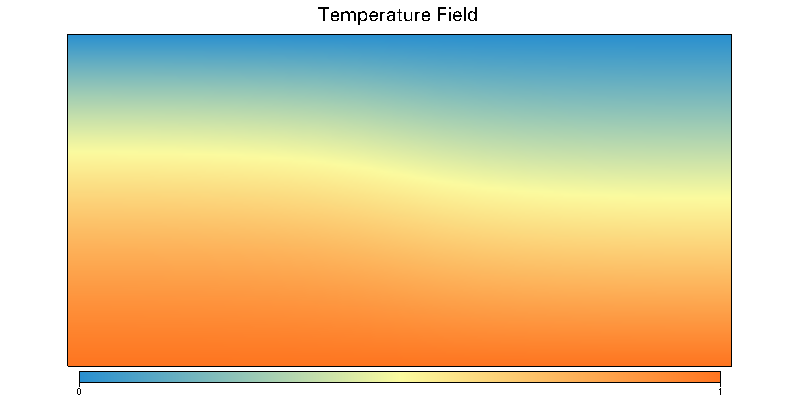

In [21]:
figMaterial = glucifer.Figure( figsize=(800,400),title="Temperature Field" )
figMaterial.append( glucifer.objects.Surface(mesh,temperatureField ))
if size == 1:
    figMaterial.show()
if savefigures:
    figMaterial.save_image("TemperatureField.png")

*Plot profiles of temperature with depth at the left wall, centre and right wall. The walls should agree with the analytic solutions with and without advection ... unless you're playing around with the geometry. Then they're a useful reference!*

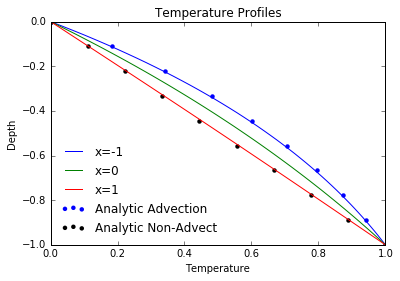

In [22]:
n = 50
arrY = numpy.linspace(-1.,0.,n)
arrT = numpy.zeros(n)

if rank == 0:
    plt.clf()

for xpos in [-1.,0.,1.]:
    arrT = numpy.zeros(n)
    for i in range(n):
        arrT[i] = temperatureField.evaluate_global((xpos,arrY[i]))

    if rank == 0:
        plt.plot(arrT,arrY,label="x=%i" %xpos)


# Analytic Solution
if rank == 0:
    arrY = numpy.linspace(-1.,0.,10)
    arrAnalytic = numpy.zeros(10)
    for i in range(10):
        arrAnalytic[i] = analyticsol(arrY[i])

    plt.scatter(arrAnalytic,arrY,label="Analytic Advection",lw=0,c="Blue")
    plt.scatter(-1. * arrY,arrY, label="Analytic Non-Advect",lw=0,c="Black")

    plt.legend(loc=0,frameon=False)
    plt.xlabel('Temperature')
    plt.ylabel('Depth')

    plt.xlim(0,1)
    plt.ylim(-1,0)
    plt.title('Temperature Profiles')
    if size == 1:
        plt.show()
    if savefigures:
        plt.savefig("Geotherms.pdf")

**Now go feel free to go back and make some changes:**

1. Lower the maximum groundwater pressure until the perturbed geotherm is colder than the linear geotherm
2. Remove the low permeability material completely (i.e. give everything a high permeability) and check that the analaytical solution almost exact. Then explore how wide the high permeablity zone has to be for it to be effectively 1D
3. Go to where the materials are set up and make some more complicated geometries.
4. Set up a horizontal groundwater pressure gradient, make sure the thermal diffusivity is homogeneous over the domain and turn off gravity. You will need to alter the boundary conditions. If done correctly, the temperature field should not be perturbed.
5. What does the ratio of hydraulic diffusivity to storage control?